In [1]:
# Import libraries
import os
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
import fnmatch
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm
import copy


# Define the device and data repository
device = 'cpu'

In [46]:
# def transform_image(image_path,target_height, target_witdth):
#     image = Image.open(image_path)
#     transform = transforms.Resize(size = (target_height,target_witdth))
#     image = transform(image)
#     return image

def find_files(directory, pattern='*.jpeg'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list
    
def resize_folder(dir_path,target_height,target_witdth):
    list_image_path = find_files(dir_path)
    for image_path in tqdm(list_image_path):
        #resize image
        image = Image.open(image_path)
        transform = transforms.Resize(size = (target_height,target_witdth))
        new_image = transform(image)
        
        main_dataset = image_path.split('/')[0]
        sub_dataset = image_path.split('/')[1]
        label = image_path.split('/')[2]
        file = image_path.split('/')[-1]
        file = file.split('.')[0]
        new_folder = str(main_dataset)+'/'+str(sub_dataset)+'_resized_'+str(target_height)+'_'+str(target_witdth)+'/'+str(label)+'/'
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)
        new_image.save(os.path.join(new_folder, file +'_resized'+'.jpeg'), 'JPEG', optimize=True)
    resized_folder = str(main_dataset)+'/'+str(sub_dataset)+'_resized_'  +str(target_height)+'_'+str(target_witdth)  
    return str(resized_folder)

In [39]:
# Resize image for training
train_path = 'Dataset/train'
resized_train_path = resize_folder(train_path,target_height=256,target_witdth=256)
print(resized_train_path)

# Resize image for validation
valid_path = 'Dataset/val'
resized_valid_path = resize_folder(valid_path,target_height=256,target_witdth=256)
print(resized_valid_path)

# Resize image for testing
test_path = 'Dataset/test'
resized_test_path = resize_folder(test_path,target_height=256,target_witdth=256)
print(resized_test_path)

100%|███████████████████████████████████████████████████████████████████████████████| 5216/5216 [02:29<00:00, 34.82it/s]


Dataset/train_resized_


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 29.31it/s]


Dataset/val_resized_


100%|█████████████████████████████████████████████████████████████████████████████████| 624/624 [00:17<00:00, 35.62it/s]

Dataset/test_resized_


In [3]:
class XrayDataset(Dataset):

    def __init__(self, image_dir):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))
        self.classes = self._get_class()
        self.class_to_idx  = self._get_class_index()

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        """Return a data sample (=image) for a given index, along with the name of the corresponding pokemon."""
        
        # TO DO:
        image_path = self.image_path_list[index]
        label = image_path.split('/')[-2]
        label = self.class_to_idx[label]
        x = io.imread(image_path, as_gray = True)
#         if len(x.shape)==3:
#             x = x[:,:,0]
        image_np = x / np.max(x)
#         x = torch.tensor(image_np, dtype=float)
        x = torch.tensor(image_np).float()
        x = x.unsqueeze(0)
        return x, label

    def _find_files(self, directory, pattern='*.jpeg'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list
    
    def _get_class(self):
        classes = []
        for path in self.image_path_list:
            class_image = path.split('/')[2]
            if class_image not in classes:
                classes.append(class_image)
        return classes
    
    def _get_class_index(self):
        idx_to_class = {i:j for i, j in enumerate(self.classes)}
        class_to_idx = {value:key for key,value in idx_to_class.items()}
        return class_to_idx

In [47]:
# We can initialize the dataset by providing the directory of the image corpus data
train_dataset = XrayDataset(image_dir='Dataset/train_resized_256_256')

valid_dataset = XrayDataset(image_dir='Dataset/val_resized_256_256')

test_dataset = XrayDataset(image_dir='Dataset/test_resized_256_256')

In [48]:
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [56]:
class CNNClassif(nn.Module):
    def __init__(self, num_channels=[1, 16, 32, 16, 4], num_classes=10):
        super(CNNClassif, self).__init__()
        
        # TO DO: define the convolutional layers 1 and 2 and the linear layer as above.
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(num_channels[0], num_channels[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
            
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(num_channels[1], num_channels[2], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(num_channels[2], num_channels[3], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(num_channels[3], num_channels[4], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        dim = 256 // (2 ** (len(num_channels)-1))
        self.lin_layer1 = nn.Linear(dim*dim*num_channels[-1], dim*num_channels[-1])
        self.lin_layer2 = nn.Linear(dim*num_channels[-1], num_classes)
        
                
    def forward(self, x): 
        # TO DO: write the forward pass, which:
        # - applies the two cnn layers to produce feature maps
        # - vectorize the feature maps
        # - applies the linear layer
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = self.cnn_layer3(out)
        out = self.cnn_layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer1(out)
        out = self.lin_layer2(out)

        
        return out 


In [17]:
# Instantiate the model
num_channels = [1, 16, 32, 16, 4]
num_classes = 2
model = CNNClassif([1, 16, 32, 16, 4], num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  12054


In [12]:
#  Training function 

def training_cnn_classifier(model_or, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Set the model
    # model = model.to(device)
    model = copy.deepcopy(model_or)
    model.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    loss_total = []
    
    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in enumerate(train_dataloader):
            # copy images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, save the average loss over batches and display it
        loss_total.append(loss_current_epoch)
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_total

In [24]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader, device):
    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    # model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            # images = images.to(device)
            # labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

Epoch [1/20], Loss: 112.4995
Epoch [2/20], Loss: 91.6805
Epoch [3/20], Loss: 91.2237
Epoch [4/20], Loss: 90.7147
Epoch [5/20], Loss: 90.0407
Epoch [6/20], Loss: 89.2162
Epoch [7/20], Loss: 88.2445
Epoch [8/20], Loss: 86.2063
Epoch [9/20], Loss: 84.0882
Epoch [10/20], Loss: 79.2454
Epoch [11/20], Loss: 71.5142
Epoch [12/20], Loss: 60.9510
Epoch [13/20], Loss: 53.6833
Epoch [14/20], Loss: 45.8892
Epoch [15/20], Loss: 45.2200
Epoch [16/20], Loss: 38.9854
Epoch [17/20], Loss: 38.2713
Epoch [18/20], Loss: 37.3195
Epoch [19/20], Loss: 31.5767
Epoch [20/20], Loss: 32.9958


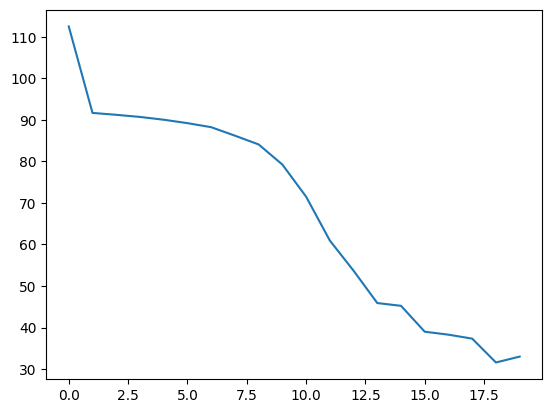

In [18]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_cnn, loss_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model_cnn.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total)
plt.show()

In [55]:
model = CNNClassif([1, 16, 32, 16, 4], num_classes)
model_cnn.load_state_dict(torch.load('model_cnn_classif.pt'))
accuracy = eval_cnn_classifier(model_cnn, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  80.76923076923077 %


In [54]:
len(test_dataloader)

78

In [49]:
data_iter = iter(test_dataloader)

In [50]:
image = data_iter.next()[0]

In [35]:
a = model_cnn(image)

In [36]:
a

tensor([[ 4.2951, -2.1590],
        [ 4.8111, -2.5850],
        [ 2.8336, -0.9518],
        [ 0.4874,  1.9945],
        [ 2.8590, -0.7918],
        [ 3.8748, -1.6120],
        [ 5.6868, -3.6495],
        [ 1.5426,  1.3983]], grad_fn=<AddmmBackward0>)